# TFT with Titanic Data

## 1. import packages

In [1]:
import os

import apache_beam as beam

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam

from tfx_bsl.public import tfxio
from tfx_bsl.coders.example_coder import RecordBatchToExamples

## 2. Load Dataset

In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("D:\\Study\\ML\\So1s-Study\\일섭\\week2\\titanic\\data\\train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("D:\\Study\\ML\\So1s-Study\\일섭\\week2\\titanic\\data\\eval.csv", TEST_DATA_URL)

In [3]:
BASE_DIR = os.path.join('D:\\Study\\ML\\So1s-Study\\일섭\\week2', 'titanic')
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
TRAIN_DATA = os.path.join(DATA_DIR, 'train_num.csv')
TEST_DATA = os.path.join(DATA_DIR, 'eval_num.csv')

os.path.isdir(BASE_DIR), os.path.isdir(DATA_DIR), os.path.isdir(OUTPUT_DIR), os.path.isfile(TRAIN_DATA),  os.path.isfile(TEST_DATA)

(True, True, True, True, True)

In [5]:
SELECTED_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'n_siblings_spouses', 'parch', 'fare']
CATEGORICAL_COLUMNS = ['class', 'deck', 'sex', 'embark_town', 'alone']
LABEL_KEY = 'survived'

# 처음에 컬럼이름을 문자열로 했는데 자꾸 컬럼이름을 float 형태로 바꾸려는 시도를 해서 오류가 나서 바꿈.
SELECTED_COLUMNS = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
NUMERIC_COLUMNS = ['3', '4', '5', '6']
CATEGORICAL_COLUMNS = ['2', '7', '8', '9', '10']
LABEL_KEY = '1'

TRANSFORMED_TRAIN_DATA_FILEBASE='train_transformed'
TRANSFORMED_TEST_DATA_FILEBASE='test_transformed'

NUM_OOV_BUCKETS = 1

## 3. Preprocessing Function

In [6]:
def preprocessing_fn(inputs):
    outputs = inputs.copy()
    
    #NUMERIC Data
    for key in NUMERIC_COLUMNS:
        outputs[key] = tft.scale_to_0_1(inputs[key])
    
    # CATEGORI Data
    for key in CATEGORICAL_COLUMNS:
        outputs[key] = tft.compute_and_apply_vocabulary(
            tf.strings.strip(inputs[key]),
            num_oov_buckets=NUM_OOV_BUCKETS,
            vocab_filename=key)
        
    # Label
    table_keys = ['0', '1']
    with tf.init_scope():
        initializer = tf.lookup.KeyValueTensorInitializer(
            keys=table_keys,
            values=tf.cast(tf.range(len(table_keys)), tf.int64),
            key_dtype=tf.string,
            value_dtype=tf.int64)
        table = tf.lookup.StaticHashTable(initializer, default_value=-1)
    
    label_str = inputs[LABEL_KEY]
    label_str = tf.strings.strip(label_str)
    data_labels = table.lookup(label_str)
    transformed_label = tf.one_hot(
        indices=data_labels, depth=2, on_value=1.0, off_value=0.0)
    outputs[LABEL_KEY] = tf.reshape(transformed_label, [-1, len(table_keys)])
    
    return outputs

## 4. Metadata

In [7]:
titanic_data_feature_meta = dict(
    [(key, tf.io.FixedLenFeature([], tf.string)) for key in CATEGORICAL_COLUMNS] +
    [(key, tf.io.FixedLenFeature([], tf.float32)) for key in NUMERIC_COLUMNS] + 
    [(LABEL_KEY, tf.io.FixedLenFeature([], tf.string))]
)

schema = tft.tf_metadata.dataset_metadata.DatasetMetadata(
    tft.tf_metadata.schema_utils.schema_from_feature_spec(titanic_data_feature_meta)).schema

titanic_data_feature_meta

{'2': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 '7': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 '8': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 '9': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 '10': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 '3': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '4': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '5': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '6': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '1': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}

## 5. Transform Function

In [8]:
def transform_data(train_data_file, test_data_file, working_dir):
    with beam.Pipeline() as pipeline:
        with tft_beam.Context(temp_dir=os.path.join(working_dir)):

            # dataset load
            train_csv_tfxio = tfxio.CsvTFXIO(
                file_pattern=train_data_file,
                telemetry_descriptors=[],
                column_names=SELECTED_COLUMNS,
                schema=schema)

            raw_data = (
                pipeline |
                'ReadTrainCsv' >> train_csv_tfxio.BeamSource())
            
            raw_dataset = (raw_data, train_csv_tfxio.TensorAdapterConfig())

            #transform
            transformed_dataset, transform_fn = (
                raw_dataset | tft_beam.AnalyzeAndTransformDataset(
                    preprocessing_fn, output_record_batches=True))

            transformed_data, _ = transformed_dataset

            _ = (
                transformed_data
                | 'EncodeTrainData' >>
                beam.FlatMapTuple(lambda batch, _: RecordBatchToExamples(batch))
                | 'WriteTrainData' >> beam.io.WriteToTFRecord(
                    os.path.join(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE)))
            
            test_csv_tfxio = tfxio.CsvTFXIO(
                file_pattern=test_data_file,
                skip_header_lines=1,
                telemetry_descriptors=[],
                column_names=SELECTED_COLUMNS,
                schema=schema)
            raw_test_data = (
                pipeline |
                'ReadTestCsv' >> test_csv_tfxio.BeamSource())
            
            raw_test_dataset = (raw_test_data, test_csv_tfxio.TensorAdapterConfig())

            #transform
            transformed_test_dataset = (
                (raw_test_dataset, transform_fn)
                | tft_beam.TransformDataset(output_record_batches=True))

            transformed_test_data, _ = transformed_test_dataset

            _ = (
                transformed_test_data
                | 'EncodeTestData' >>
                beam.FlatMapTuple(lambda batch, _: RecordBatchToExamples(batch))
                | 'WriteTestData' >> beam.io.WriteToTFRecord(
                    os.path.join(working_dir, TRANSFORMED_TEST_DATA_FILEBASE)))
        
        
            # 이부분에서 ValueError : string to float b'age' 에러가 남.
            _ = (transform_fn | 'WriteTransformFn' >> tft_beam.WriteTransformFn(working_dir))

In [9]:
transform_data(TRAIN_DATA,TEST_DATA,OUTPUT_DIR)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


:::::


INFO:tensorflow:Assets written to: D:\Study\ML\So1s-Study\일섭\week2\titanic\output\tftransform_tmp\bf8a774ba0d6422a89b9371be44dc0cf\assets


INFO:tensorflow:Assets written to: D:\Study\ML\So1s-Study\일섭\week2\titanic\output\tftransform_tmp\bf8a774ba0d6422a89b9371be44dc0cf\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: D:\Study\ML\So1s-Study\일섭\week2\titanic\output\tftransform_tmp\cbe6258fe448477fa0c1ac477e4e9529\assets


INFO:tensorflow:Assets written to: D:\Study\ML\So1s-Study\일섭\week2\titanic\output\tftransform_tmp\cbe6258fe448477fa0c1ac477e4e9529\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


# Dataset Read

## 1. Read Metadata

In [10]:
tf_transform_output = tft.TFTransformOutput(OUTPUT_DIR)

In [11]:
tf_transform_output.transformed_feature_spec()

{'1': FixedLenFeature(shape=[2], dtype=tf.float32, default_value=None),
 '10': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 '2': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 '3': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '4': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '5': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '6': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 '7': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 '8': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 '9': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}

## 2. Read Dataset for Training

In [12]:
def _make_training_input_fn(tf_transform_output, train_file_pattern, batch_size):
    def input_fn():
        return tf.data.experimental.make_batched_features_dataset(
            file_pattern=train_file_pattern,
            batch_size=batch_size,
            features=tf_transform_output.transformed_feature_spec(),
            reader=tf.data.TFRecordDataset,
            label_key=LABEL_KEY,
            shuffle=True)

    return input_fn

In [13]:
train_file_pattern = pathlib.Path(OUTPUT_DIR)/f'{TRANSFORMED_TRAIN_DATA_FILEBASE}*'

input_fn = _make_training_input_fn(
    tf_transform_output=tf_transform_output,
    train_file_pattern = str(train_file_pattern),
    batch_size = 10
)

In [14]:
for example, label in input_fn().take(1):
    # print(pd.DataFrame(example)['10'].values)
    break

pd.DataFrame(example)

,10,2,3,4,5,6,7,8,9
0,0,0,0.230284,0.000,0.0,0.013175,0,0,2
1,0,0,0.444795,0.000,0.0,0.000000,0,0,0
2,0,0,0.343849,0.000,0.0,0.015713,0,0,0
3,0,0,0.520505,0.000,0.0,0.014737,0,0,0
4,1,0,0.501577,0.000,0.4,0.028302,0,0,0
5,1,1,0.747634,0.125,0.0,0.146878,1,4,1
6,0,1,0.520505,0.000,0.0,0.444099,1,0,1
7,0,0,0.343849,0.000,0.0,0.027058,2,0,1
8,1,0,0.305994,0.125,0.0,0.015176,0,0,0
9,0,0,0.343849,0.000,0.0,0.016510,0,0,2


In [15]:
label

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)>

In [16]:
def build_keras_model(working_dir):
    inputs = build_keras_inputs(working_dir)

    encoded_inputs = encode_inputs(inputs)

    stacked_inputs = tf.concat(tf.nest.flatten(encoded_inputs), axis=1)
    output = tf.keras.layers.Dense(100, activation='relu')(stacked_inputs)
    output = tf.keras.layers.Dense(50, activation='relu')(output)
    output = tf.keras.layers.Dense(2)(output)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

In [17]:
def build_keras_inputs(working_dir):
    tf_transform_output = tft.TFTransformOutput(working_dir)

    feature_spec = tf_transform_output.transformed_feature_spec().copy()
    feature_spec.pop(LABEL_KEY)

    # Build the `keras.Input` objects.
    inputs = {}
    for key, spec in feature_spec.items():
        if isinstance(spec, tf.io.VarLenFeature):
            inputs[key] = tf.keras.layers.Input(
                shape=[None], name=key, dtype=spec.dtype, sparse=True)
        elif isinstance(spec, tf.io.FixedLenFeature):
            inputs[key] = tf.keras.layers.Input(
                shape=spec.shape, name=key, dtype=spec.dtype)
        else:
            raise ValueError('Spec type is not supported: ', key, spec)

    return inputs

In [18]:
def encode_inputs(inputs):
    encoded_inputs = {}
    for key in inputs:
        feature = tf.expand_dims(inputs[key], -1)
        if key in CATEGORICAL_COLUMNS:
            num_buckets = tf_transform_output.num_buckets_for_transformed_feature(key)
            encoding_layer = (
                tf.keras.layers.CategoryEncoding(
                    num_tokens=num_buckets, output_mode='binary', sparse=False))
            encoded_inputs[key] = encoding_layer(feature)
        else:
            encoded_inputs[key] = feature
  
    return encoded_inputs

In [19]:
model = build_keras_model(OUTPUT_DIR)

tf.keras.utils.plot_model(model,rankdir='LR', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [20]:
def get_dataset(working_dir, filebase):
    tf_transform_output = tft.TFTransformOutput(working_dir)

    data_path_pattern = os.path.join(
        working_dir,
        filebase + '*')

    input_fn = _make_training_input_fn(
        tf_transform_output,
        data_path_pattern,
        batch_size=BATCH_SIZE)

    dataset = input_fn()

    return dataset

In [21]:
def train_and_evaluate(model, working_dir):
    train_dataset = get_dataset(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE)
    validation_dataset = get_dataset(working_dir, TRANSFORMED_TEST_DATA_FILEBASE)

    model = build_keras_model(working_dir)

    history = train_model(model, train_dataset, validation_dataset)

    metric_values = model.evaluate(validation_dataset,
                                 steps=EVALUATION_STEPS,
                                 return_dict=True)
    return model, history, metric_values

In [22]:
def train_model(model, train_dataset, validation_dataset):
    model.compile(optimizer='adam',
                  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_dataset, validation_data=validation_dataset,
        epochs=TRAIN_NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_TRAIN_EPOCH,
        validation_steps=EVALUATION_STEPS)
    return history

In [ ]:
pandas_train = pd.read_csv(TRAIN_DATA, header=None, names=SELECTED_COLUMNS)
pandas_test = pd.read_csv(TEST_DATA, header=1, names=SELECTED_COLUMNS)

COLUMN_DEFAULTS = [
  '' if isinstance(v, str) else 0.0
  for v in  dict(pandas_train.loc[1]).values()]

EPOCH_SPLITS = 10
TRAIN_NUM_EPOCHS = 2*EPOCH_SPLITS
NUM_TRAIN_INSTANCES = len(pandas_train)
NUM_TEST_INSTANCES = len(pandas_test)

BATCH_SIZE = 128

STEPS_PER_TRAIN_EPOCH = tf.math.ceil(NUM_TRAIN_INSTANCES/BATCH_SIZE/EPOCH_SPLITS)
EVALUATION_STEPS = tf.math.ceil(NUM_TEST_INSTANCES/BATCH_SIZE)

# Names of temp files
TRANSFORMED_TRAIN_DATA_FILEBASE = 'train_transformed'
TRANSFORMED_TEST_DATA_FILEBASE = 'test_transformed'
EXPORTED_MODEL_DIR = 'exported_model_dir'

In [ ]:
model, history, metric_values = train_and_evaluate(model, OUTPUT_DIR)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.7419 - accuracy: 0.3359 - val_loss: 0.7248 - val_accuracy: 0.3229
Epoch 2/20
1/1 [==============================] - 0s 103ms/step - loss: 0.7297 - accuracy: 0.2656 - val_loss: 0.7095 - val_accuracy: 0.3776
Epoch 3/20
1/1 [==============================] - 0s 125ms/step - loss: 0.7028 - accuracy: 0.4375 - val_loss: 0.6907 - val_accuracy: 0.5651
Epoch 4/20
1/1 [==============================] - 0s 112ms/step - loss: 0.6913 - accuracy: 0.5781 - val_loss: 0.6775 - val_accuracy: 0.6094
Epoch 5/20
1/1 [==============================] - 0s 88ms/step - loss: 0.6591 - accuracy: 0.6875 - val_loss: 0.6626 - val_accuracy: 0.6328
Epoch 6/20
1/1 [==============================] - 0s 122ms/step - loss: 0.6516 - accuracy: 0.6406 - val_loss: 0.6493 - val_accuracy: 0.6432
Epoch 7/20
1/1 [==============================] - 0s 101ms/step - loss: 0.6377 - accuracy: 0.6797 - val_loss: 0.6379 - val_accuracy: 0.6432
Epoch 8/20
1/1 [========

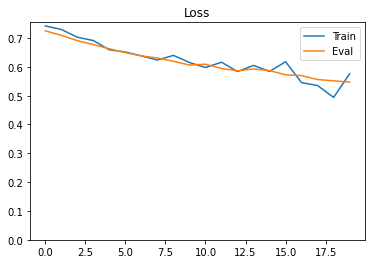

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Eval')
plt.ylim(0,max(plt.ylim()))
plt.legend()
plt.title('Loss');